# Contents:
- [1. Import Libraries & Data](#import-libraries)
- [2. Data Preprocessing](#data-preprocessing)
- [3. Models Experiments](#models)
    - [3.1 All Features](#All-Features)
    - [3.2 Feature-Selection](#Feature-Selection)
    - [3.3 Feature Selection using PCA](#Feature-Selection-PCA)
- [4. ANN](#ann)

<a id="import-libraries"></a>
# 1. Import Libraries & Data

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import random
np.random.seed(1)

#warnings.filterwarnings('ignore')

# preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# models 
from sklearn.linear_model import LinearRegression
from sklearn. linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import BayesianRidge
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from lightgbm import LGBMRegressor
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

# evaluation
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

In [ ]:
data = pd.read_csv('../../data/final/clean_trial4.csv')

In [3]:
data.head(2)

,logkpl,Compound,SMILES,Texpi,ALogp2,nAcid,nAromBond,ATSc2,ATSc3,ATSc4,...,nRings9,TopoPSA,VAdjMat,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,XLogP,Zagreb
0,-3.55,Urea,C(=O)(N)N,312,1.085972,0,0,-0.116019,0.023614,0.0,...,0,69.11,2.584963,1.683013,6.732051,2.244017,4.488034,9.0,-1.686,12.0
1,-3.69,Urea,C(=O)(N)N,312,1.085972,0,0,-0.116019,0.023614,0.0,...,0,69.11,2.584963,1.683013,6.732051,2.244017,4.488034,9.0,-1.686,12.0


In [4]:
smiles_df = data[['SMILES', 'Compound']]
smiles_df.head(2)

,SMILES,Compound
0,C(=O)(N)N,Urea
1,C(=O)(N)N,Urea


In [5]:
data.shape

(417, 149)

In [6]:
data[data.duplicated()]

,logkpl,Compound,SMILES,Texpi,ALogp2,nAcid,nAromBond,ATSc2,ATSc3,ATSc4,...,nRings9,TopoPSA,VAdjMat,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,XLogP,Zagreb


In [7]:
# no missing values
data.isna().sum().sum()

0

<a id="data-preprocessing"></a>
# 2. Data Preprocessing

In [8]:
model_data = data.drop(["SMILES", 'Compound'], axis=1)

In [9]:
X = model_data.drop(["logkpl"], axis=1)
y = model_data['logkpl']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.15)

print("Shape of X_train: {} \t Shape of y_train: {}".format(X_train.shape, y_train.shape))
print("Shape of X_test: {} \t Shape of y_test: {}".format(X_test.shape, y_test.shape))

Shape of X_train: (354, 146) 	 Shape of y_train: (354,)
Shape of X_test: (63, 146) 	 Shape of y_test: (63,)


In [ ]:
with open('../../models/scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

<a id="models"></a>
# 3. Models Experiments

In [10]:
def plot_feature_importance(model, cols, model_name, slice=20):
    importances = model.feature_importances_
    feature_names = cols#X.columns#selected_features_X.columns #

    # Create a pandas DataFrame with the feature importances
    df = pd.DataFrame({"feature": feature_names, "importance": importances})

    # Sort the DataFrame by importance score
    df = df.sort_values("importance", ascending=False).reset_index(drop=True)
    df[:slice].to_excel("../../results/Feature Importance/{}_feature_importance.xlsx".format(model_name), index=False)

    # Create a bar plot using Seaborn
    plt.figure(figsize=(12, 8))
    sns.set_style("whitegrid")
    sns.barplot(x="importance", y="feature", data=df[:slice])
    plt.title("Top 20 Feature Importances {}".format(model_name))
    plt.ylabel("Feature Name")
    plt.xlabel("Importance")
    plt.show()

<a id="All-Features"></a>
### 3.1 All Features

In [11]:
def ANN_model(X_train, X_test, y_train, y_test):
    
    model = tf.keras.Sequential([

    tf.keras.layers.Dense(256, input_shape=[X_train.shape[1]]),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8),
    tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss="mean_absolute_error")

    history = model.fit(X_train, y_train, epochs=2500, validation_data=(X_test, y_test), verbose=2)

    plt.title('Learning Curves')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

    predictions = model.predict(X_test)

    # MAE, MSE, RMSE
    print("MAE: {}".format(mean_absolute_error(y_test, predictions)))
    print("MSE: {}".format(mean_squared_error(y_test, predictions)))
    print("RMSE: {}".format(mean_squared_error(y_test, predictions, squared=False)))
    print("MAPE: {}".format(mean_absolute_percentage_error(y_test, predictions)))
    print("R2: {}".format(r2_score(y_test, predictions)))

    final_result = pd.DataFrame({"predicted": model.predict(X_test).reshape(X_test.shape[0],), 
              "actual": y_test})
    
    # saving the model

# serialize model to JSON
    model_json = model.to_json()
    with open("../../models/ANN_model.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("../../models/ANN_model.h5")
    print("Saved model to disk")

    # load json and create model
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# loaded_model.predict(X_test[0].reshape((1, 512, 512, 1))).argmax(axis=1)
# print("Loaded model from disk")
    
    return final_result.reset_index(drop=True)

In [16]:
def evaluate_model(model_df, i, model_name, model, X_train, y_train, X_test, y_test):
    """
    this function is for regression takes the model with the data and calculate
    the scores, with cross validation techniques, in addition to MAE, MSE, RMSE, MAPE
    R Squared and Adjusted R Squared

    :param model: model
    :param X_train, X_test, y_train, y_test: data that was used
    """

    # cross validation with 5 folds
    all_cv_5 = cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_absolute_error")
    #print("all CV 5: {}".format(all_cv_5))
    # print("Mean Cross-Validation score: {}".format(all_cv_5.mean()))

    # predictions from our model
    predictions = model.predict(X_test)


    # calculating R squared and Adjusted R squared
    r_sqre = r2_score(y_test, predictions)
    n = len(y_test)
    p = X_test.shape[1] # number of independant features

    Adj_r2 = 1 - ((1 - r_sqre) * (n - 1) / (n - 1 - p))
    
    test_mae = mean_absolute_error(y_test, predictions)

    test_mse = mean_squared_error(y_test, predictions)
    test_rmse = np.sqrt(mean_squared_error(y_test, predictions))

    
    # Plotting
    plt.figure(figsize=(12, 8))
    plt.scatter(y_test, predictions, color='blue', label='Predicted vs Actual')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Predicted vs Actual {}'.format(model_name))
    plt.legend()
    plt.show()
    #print("=" * 40)
    model_df.loc[i] = [model_name, all_cv_5.mean(),
                    test_mae, mean_absolute_percentage_error(y_test, predictions),
                   test_mse, test_rmse, r_sqre, Adj_r2]

    return model_df

In [17]:
def train_and_evalute(X_train, X_test, y_train, y_test, metric):
    # scaler = StandardScaler()
    # X_scaled = scaler.fit_transform(X)

    # X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

    # print("Shape of X_train: {} \t Shape of y_train: {}".format(X_train.shape, y_train.shape))
    # print("Shape of X_test: {} \t Shape of y_test: {}".format(X_test.shape, y_test.shape))

    # Building pipelins of standard scaler and model for varios regressors.

    lr = LinearRegression()

    lasso = Lasso()

    dt = DecisionTreeRegressor()

    rf = RandomForestRegressor()

    xgb = XGBRegressor()

    gbr = GradientBoostingRegressor()

    eln = ElasticNet()

    br = BayesianRidge()

    cat = CatBoostRegressor(allow_writing_files=False, verbose=0, task_type="GPU")

    lgbm = LGBMRegressor()



    # List of all the pipelines
    pipelines = [lr, lasso, dt, rf, xgb, gbr,
                eln, br, cat, lgbm] # 

    # Dictionary of pipelines and model types for ease of reference
    ml_dict = {0: "LinearRegression", 1: "Lasso", 2: "DecisionTree", 3: "RandomForest", 4: "XGBRegressor", 5: "GradientBoostingRegressor",
                    6: "Elastic Net", 7:"BayesianRidge", 8: "CatBoostRegressor", 9: "LGBMRegressor"}
        #, 

    models_scores_df = pd.DataFrame(columns=["model", "Mean CV", "MAE",
                                            "MAPE", "MSE", "RMSE", "R_Squared", "Adjusted_R_Squared"])



    # Fit the pipelines and display the scores with Cross validation
    for i, pipe in enumerate(pipelines):
        # getting the name of our model
        model_name = ml_dict[i]
        print(model_name)
        
        # fitting our data
        pipe.fit(X_train, y_train)
        
        evaluate_model(models_scores_df, i, model_name, pipe, X_train, y_train, X_test, y_test)


    # selecting top 3 score based on metric
    filtered_models_scores_df =  models_scores_df.sort_values(metric).iloc[:3, :]

    results_df = pd.DataFrame({"actual": y_test})
    selected_compounds = smiles_df.iloc[results_df.index]
    results_df['Compound'] = selected_compounds['Compound']
    results_df['SMILES'] = selected_compounds['SMILES']

    results_df = results_df.reset_index(drop=True)
    li = []

    for i in filtered_models_scores_df.index:
        predictions = pipelines[i].predict(X_test)
        
        predictions_df = pd.DataFrame({"predictions_{}".format(ml_dict[i]): predictions})
        li.append(predictions_df)
        plot_feature_importance(pipelines[i],  X.columns, ml_dict[i])

        # save the model to disk
        filename = '../../models/{}_model.sav'.format(ml_dict[i])
        pickle.dump(pipelines[i], open(filename, 'wb'))

    li_df = pd.concat(li, axis=1)

    return models_scores_df, pd.concat([results_df, li_df], axis=1)
# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
# print(result)

LinearRegression


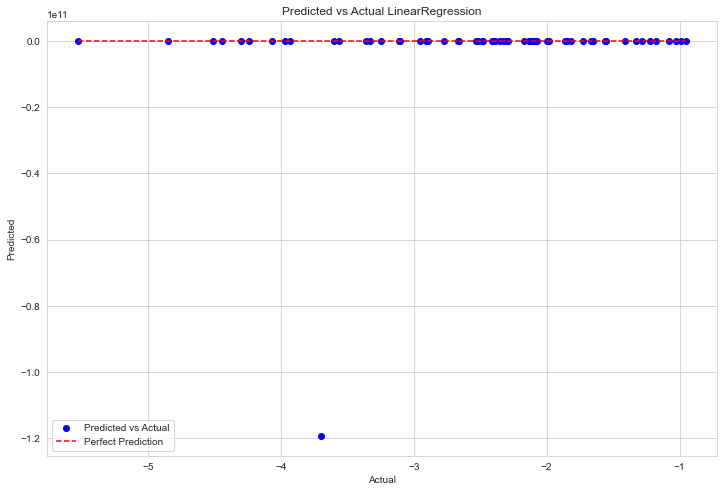

Lasso


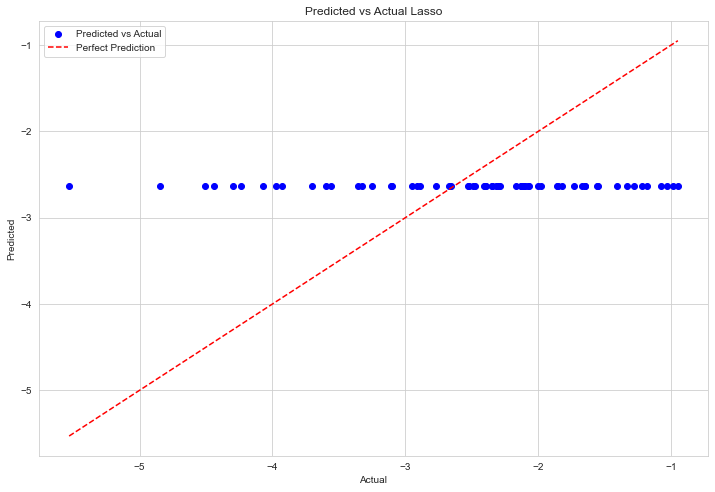

DecisionTree


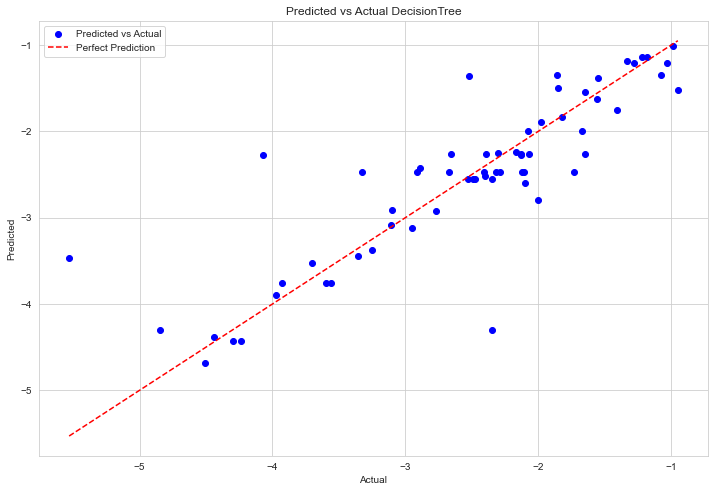

RandomForest


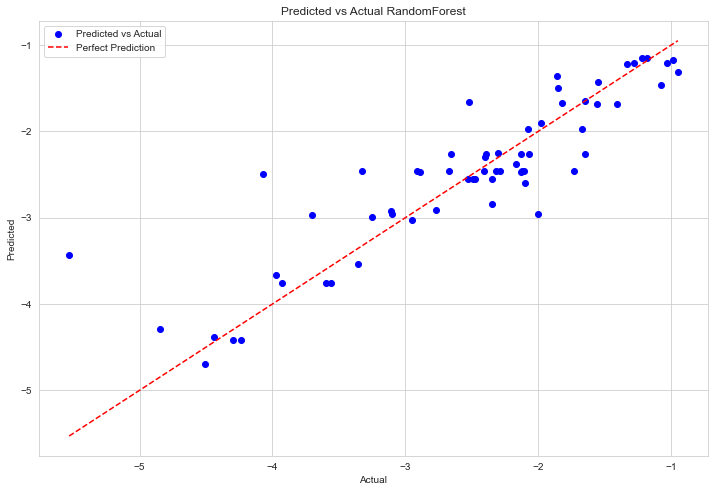

XGBRegressor


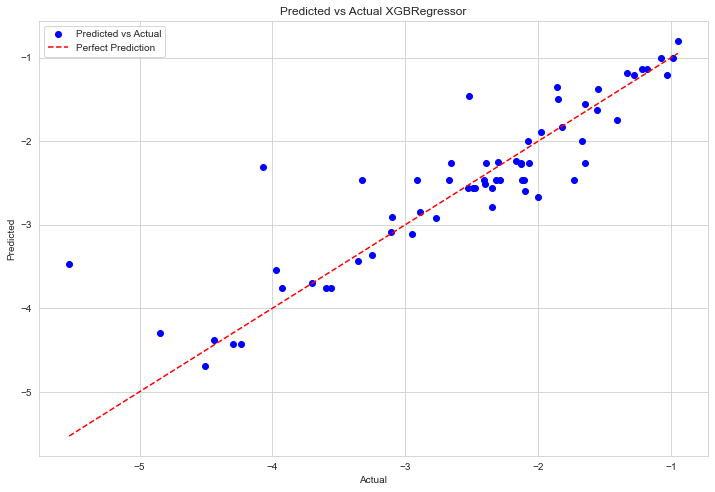

GradientBoostingRegressor


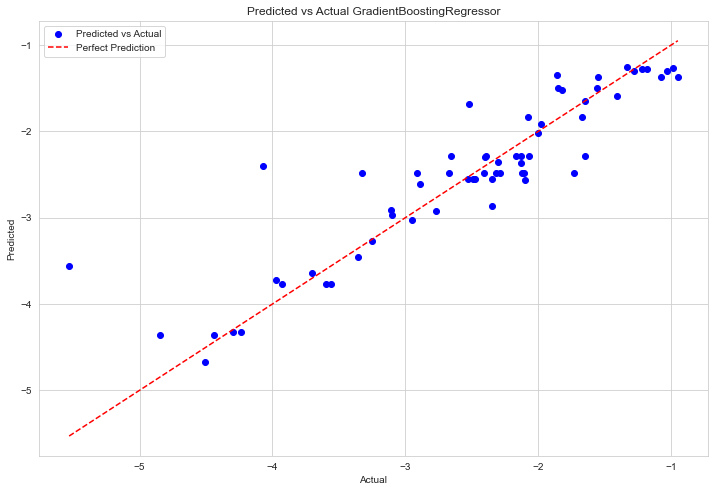

Elastic Net


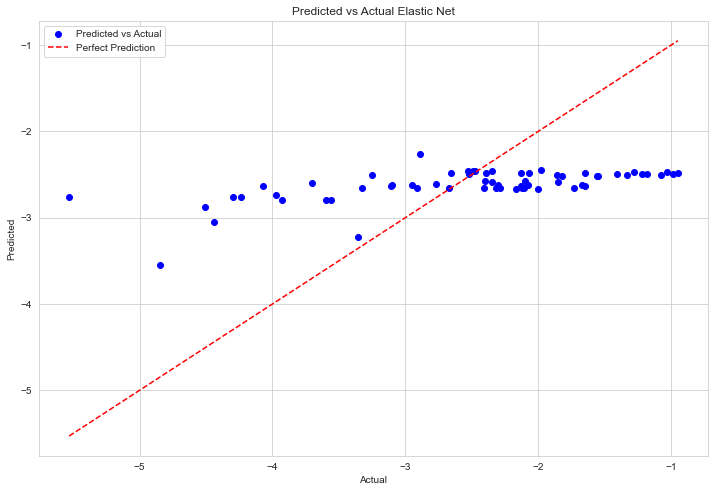

BayesianRidge


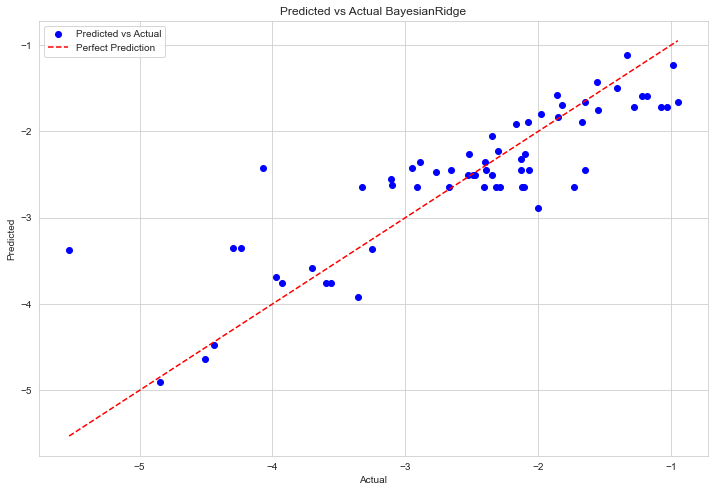

CatBoostRegressor


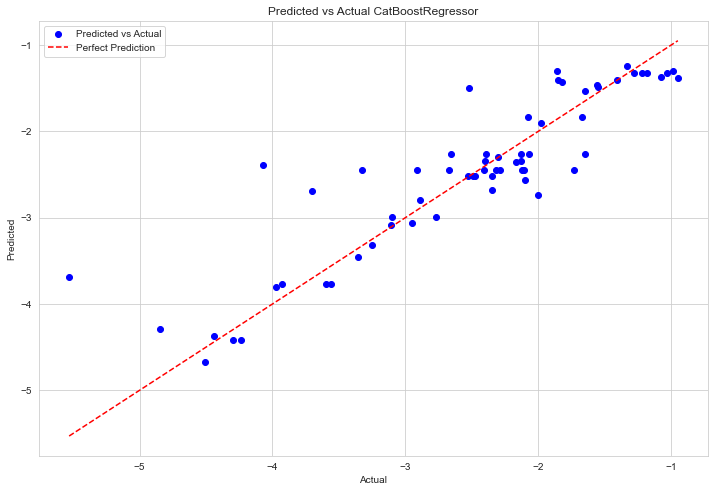

LGBMRegressor


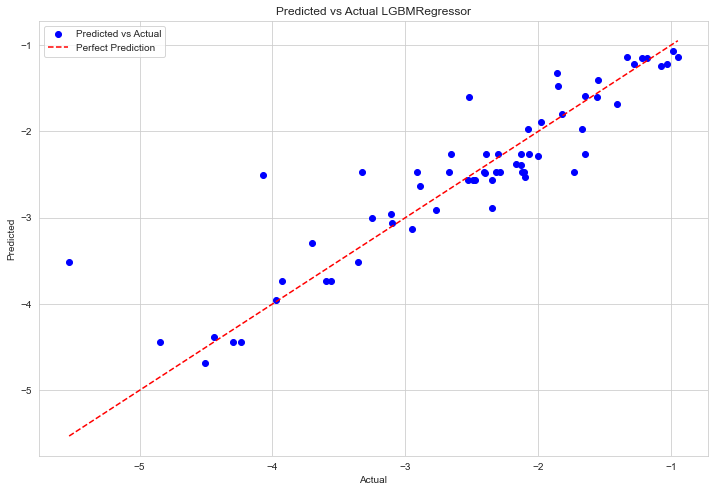

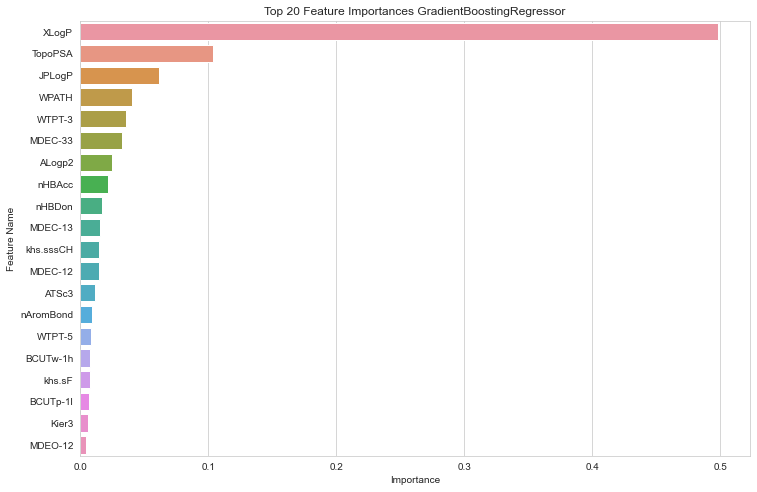

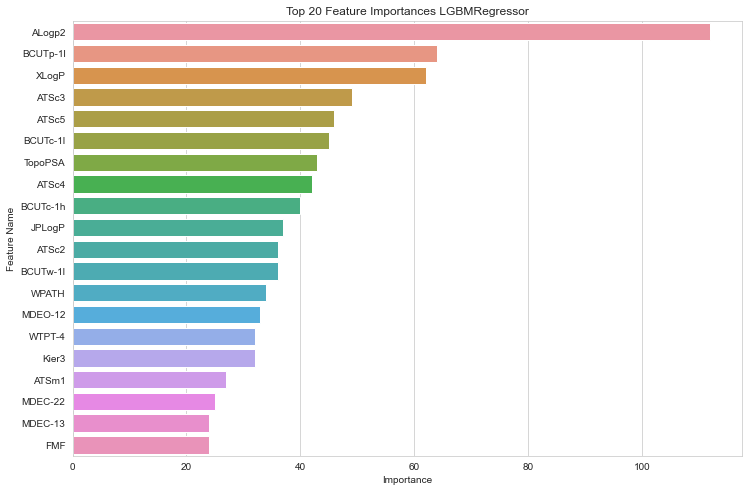

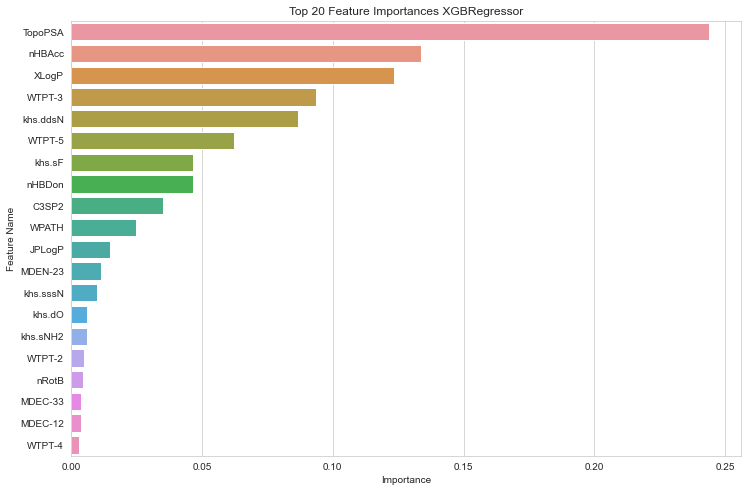

,model,Mean CV,MAE,MAPE,MSE,RMSE,R_Squared,Adjusted_R_Squared
0,LinearRegression,-6.159922e+11,1.893629e+09,5.117916e+08,2.259073e+20,1.503021e+10,-2.138483e+20,1.578404e+20
1,Lasso,-9.865381e-01,8.399749e-01,4.149462e-01,1.067373e+00,1.033138e+00,-1.039668e-02,1.745769e+00
2,DecisionTree,-4.733951e-01,3.226557e-01,1.362111e-01,2.860707e-01,5.348558e-01,7.291998e-01,1.199876e+00
3,RandomForest,-4.442795e-01,3.139151e-01,1.305893e-01,2.240232e-01,4.733109e-01,7.879352e-01,1.156524e+00
4,XGBRegressor,-4.464323e-01,2.811937e-01,1.128366e-01,2.134978e-01,4.620582e-01,7.978988e-01,1.149170e+00
5,GradientBoostingRegressor,-4.409827e-01,2.759097e-01,1.181776e-01,1.926137e-01,4.388777e-01,8.176681e-01,1.134578e+00
6,Elastic Net,-8.878485e-01,7.510306e-01,3.741900e-01,8.542022e-01,9.242306e-01,1.913953e-01,1.596827e+00
7,BayesianRidge,-5.254094e-01,3.652304e-01,1.666425e-01,2.741862e-01,5.236279e-01,7.404499e-01,1.191573e+00
8,CatBoostRegressor,-4.362737e-01,3.000598e-01,1.279687e-01,2.149384e-01,4.636145e-01,7.965351e-01,1.150176e+00
9,LGBMRegressor,-4.445913e-01,2.781161e-01,1.131221e-01,1.908129e-01,4.368214e-01,8.193727e-01,1.133320e+00


In [18]:
all_features, results_scores = train_and_evalute(X_train, X_test, y_train, y_test, metric="MAE")
all_features

In [36]:
results_scores

,actual,Compound,SMILES,predictions_LGBMRegressor,predictions_RandomForest,predictions_CatBoostRegressor
0,-3.44,Methotrexate,CN(CC1=CN=C2C(=N1)C(=NC(=N2)N)N)C3=CC=C(C=C3)C...,-3.578073,-3.377851,-2.896919
1,-2.63,Estradiol,CC12CCC3C(C1CCC2O)CCC4=C3C=CC(=C4)O,-2.583965,-2.563901,-2.596668
2,-1.09,chloroxylenol,CC1=CC(=CC(=C1Cl)C)O,-1.244920,-1.300735,-1.338873
3,-0.78,7-Ethoxycoumarin,CCOC1=CC2=C(C=C1)C=CC(=O)O2,-0.987631,-1.180592,-1.164692
4,-1.27,Propylparaben,CCCOC(=O)C1=CC=C(C=C1)O,-1.656412,-1.669596,-1.588467
...,...,...,...,...,...,...
79,-1.95,testosterone,CC12CCC3C(C1CCC2O)CCC4=CC(=O)CCC34C,-2.311926,-2.315052,-2.317046
80,-0.74,"2,4-Dichloroacetophenone",C1=CC(=CC=C1C(=O)CCl)Cl,-1.819152,-1.679086,-1.468705
81,-1.51,Benzoic acid,C1=CC=C(C=C1)C(=O)O,-2.197229,-2.238283,-2.300404
82,-4.27,sucrose,C(C1C(C(C(C(O1)OC2(C(C(C(O2)CO)O)O)CO)O)O)O)O,-4.799342,-4.821761,-4.876010


Epoch 1/2500
12/12 - 0s - loss: 3.0276 - val_loss: 2.6693 - 487ms/epoch - 41ms/step
Epoch 2/2500
12/12 - 0s - loss: 2.6881 - val_loss: 2.4670 - 32ms/epoch - 3ms/step
Epoch 3/2500
12/12 - 0s - loss: 2.7200 - val_loss: 2.3810 - 32ms/epoch - 3ms/step
Epoch 4/2500
12/12 - 0s - loss: 2.6341 - val_loss: 2.3031 - 34ms/epoch - 3ms/step
Epoch 5/2500
12/12 - 0s - loss: 2.5643 - val_loss: 2.2212 - 34ms/epoch - 3ms/step
Epoch 6/2500
12/12 - 0s - loss: 2.5761 - val_loss: 2.1628 - 34ms/epoch - 3ms/step
Epoch 7/2500
12/12 - 0s - loss: 2.4245 - val_loss: 2.1078 - 32ms/epoch - 3ms/step
Epoch 8/2500
12/12 - 0s - loss: 2.4353 - val_loss: 2.0607 - 34ms/epoch - 3ms/step
Epoch 9/2500
12/12 - 0s - loss: 2.3022 - val_loss: 2.0375 - 33ms/epoch - 3ms/step
Epoch 10/2500
12/12 - 0s - loss: 2.1871 - val_loss: 2.0046 - 34ms/epoch - 3ms/step
Epoch 11/2500
12/12 - 0s - loss: 2.0391 - val_loss: 1.9624 - 31ms/epoch - 3ms/step
Epoch 12/2500
12/12 - 0s - loss: 2.0738 - val_loss: 1.9004 - 34ms/epoch - 3ms/step
Epoch 13/25

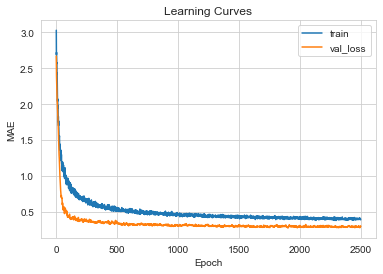

2/2 [==============================] - 0s 2ms/step
MAE: 0.2984200477600099
MSE: 0.21411811329273037
RMSE: 0.4627289847121427
MAPE: 0.12701795372242544
R2: 0.7973115637202346
2/2 [==============================] - 0s 999us/step
Saved model to disk


,predicted,actual
0,-4.092970,-3.70
1,-2.220347,-2.17
2,-2.414823,-2.11
3,-3.370315,-3.25
4,-1.313301,-1.86
...,...,...
58,-2.316139,-2.30
59,-2.414823,-2.29
60,-2.295804,-2.13
61,-1.246275,-1.22


In [29]:
final_result = ANN_model(X_train, X_test, y_train, y_test)
final_result

In [39]:
results_scores['predictions_ANN'] = final_result['predicted']

In [42]:
results_scores['mean'] = (results_scores['predictions_ANN'] + results_scores['predictions_CatBoostRegressor'] + results_scores['predictions_CatBoostRegressor'] + results_scores['predictions_XGBRegressor']) / 4

In [43]:
results_scores

,actual,Compound,SMILES,predictions_XGBRegressor,predictions_CatBoostRegressor,predictions_LGBMRegressor,predictions_ANN,mean
0,-1.41,Benzylideneacetone,CC(=O)C=CC1=CC=CC=C1,-1.121665,-1.189869,-1.121698,-1.125018,-1.156605
1,-1.82,4-propoxyphenol,CCCOC1=CC=C(C=C1)O,-1.827566,-1.468094,-1.758048,-1.514402,-1.569539
2,-2.21,Corticosterone,CC12CCC(=O)C=C1CCC3C2C(CC4(C3CCC4C(=O)CO)C)O,-2.467710,-2.438703,-2.469578,-2.466597,-2.452929
3,-1.22,"2,4-Dichlorophenol",C1=CC(=C(C=C1Cl)Cl)O,-1.190483,-1.239560,-1.219402,-1.250912,-1.230129
4,-2.79,Alprenolol,CC(C)NCC(COC1=CC=CC=C1CC=C),-1.855024,-1.756029,-1.924435,-3.096743,-2.115956
...,...,...,...,...,...,...,...,...
79,-3.93,Urea,C(=O)(N)N,-3.767368,-3.764141,-3.763079,-3.770163,-3.766453
80,-3.97,Mannitol,C(C(C(C(C(CO)O)O)O)O)O,-4.368868,-4.293529,-4.368040,-4.586554,-4.385620
81,-2.01,testosterone,CC12CCC3C(C1CCC2O)CCC4=CC(=O)CCC34C,-2.190077,-2.169239,-2.207644,-2.364748,-2.223326
82,-1.13,o-t-butylphenol,CC(C)(C)C1=CC=CC=C1O,-1.279589,-1.665958,-1.548069,0.688029,-0.980869


In [44]:
results_scores['diff'] = abs(results_scores['actual'] - results_scores['mean'])

In [46]:
results_scores.to_excel("../../results/predictions.xlsx", index=False)

<a id="Feature-Selection"></a>
### 3.2 Feature Selection

In [25]:
import statsmodels.api as sm
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [26]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

sfs1 = SFS(GradientBoostingRegressor(), 
           k_features=30,
           forward=True, 
           floating=False, 
           verbose=0,
           scoring="neg_mean_absolute_error",
           cv=0)

sfs1 = sfs1.fit(X, y)

In [27]:
# try selecting more features
sfs1.k_feature_names_

('ALogp2',
 'nAcid',
 'ATSc2',
 'ATSc5',
 'BCUTc-1h',
 'BCUTp-1l',
 'C2SP1',
 'khs.sLi',
 'khs.ssBe',
 'khs.ssBH',
 'khs.sssB',
 'khs.tCH',
 'khs.ddC',
 'khs.aasC',
 'khs.aaaC',
 'khs.sNH3',
 'khs.sNH2',
 'khs.ssNH2',
 'khs.dNH',
 'khs.tN',
 'khs.aaN',
 'khs.aasN',
 'khs.ssssN',
 'khs.sSiH3',
 'khs.ssSiH2',
 'khs.sssSiH',
 'khs.ssssSi',
 'khs.sPH2',
 'MDEN-13',
 'TopoPSA')

In [28]:
pd.DataFrame.from_dict(sfs1.get_metric_dict()).T

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(1,)",[-0.39421836888960043],-0.394218,"(ALogp2,)",NaN,0.0,NaN
2,"(1, 137)",[-0.340141933160523],-0.340142,"(ALogp2, TopoPSA)",NaN,0.0,NaN
3,"(1, 4, 137)",[-0.3145634937411719],-0.314563,"(ALogp2, ATSc2, TopoPSA)",NaN,0.0,NaN
4,"(1, 4, 13, 137)",[-0.30947901627780056],-0.309479,"(ALogp2, ATSc2, BCUTp-1l, TopoPSA)",NaN,0.0,NaN
5,"(1, 4, 12, 13, 137)",[-0.30127882765924247],-0.301279,"(ALogp2, ATSc2, BCUTc-1h, BCUTp-1l, TopoPSA)",NaN,0.0,NaN
6,"(1, 4, 7, 12, 13, 137)",[-0.29721441824348194],-0.297214,"(ALogp2, ATSc2, ATSc5, BCUTc-1h, BCUTp-1l, Top...",NaN,0.0,NaN
7,"(1, 4, 7, 12, 13, 43, 137)",[-0.29323641590752386],-0.293236,"(ALogp2, ATSc2, ATSc5, BCUTc-1h, BCUTp-1l, khs...",NaN,0.0,NaN
8,"(1, 4, 7, 12, 13, 16, 43, 137)",[-0.29323641590752386],-0.293236,"(ALogp2, ATSc2, ATSc5, BCUTc-1h, BCUTp-1l, C2S...",NaN,0.0,NaN
9,"(1, 2, 4, 7, 12, 13, 16, 43, 137)",[-0.29323641590752386],-0.293236,"(ALogp2, nAcid, ATSc2, ATSc5, BCUTc-1h, BCUTp-...",NaN,0.0,NaN
10,"(1, 2, 4, 7, 12, 13, 16, 43, 119, 137)",[-0.29197973071463557],-0.29198,"(ALogp2, nAcid, ATSc2, ATSc5, BCUTc-1h, BCUTp-...",NaN,0.0,NaN


Shape of X_train: (337, 30) 	 Shape of y_train: (337,)
Shape of X_test: (113, 30) 	 Shape of y_test: (113,)
LinearRegression
Lasso
DecisionTree
RandomForest
XGBRegressor
GradientBoostingRegressor
Elastic Net
BayesianRidge
CatBoostRegressor
LGBMRegressor


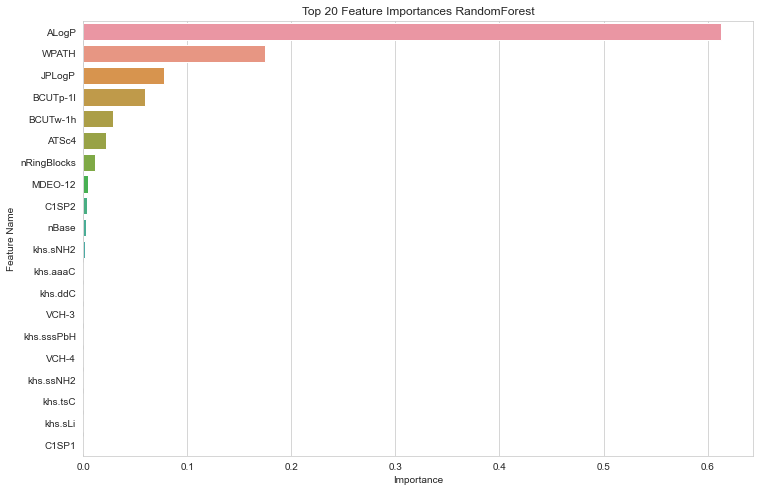

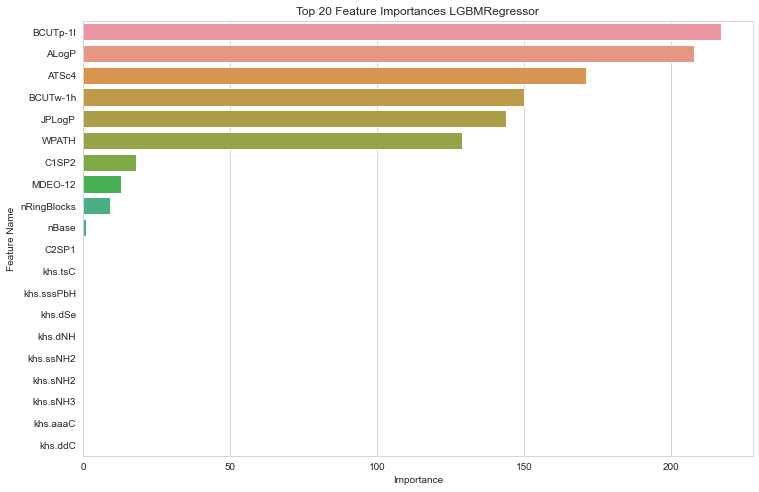

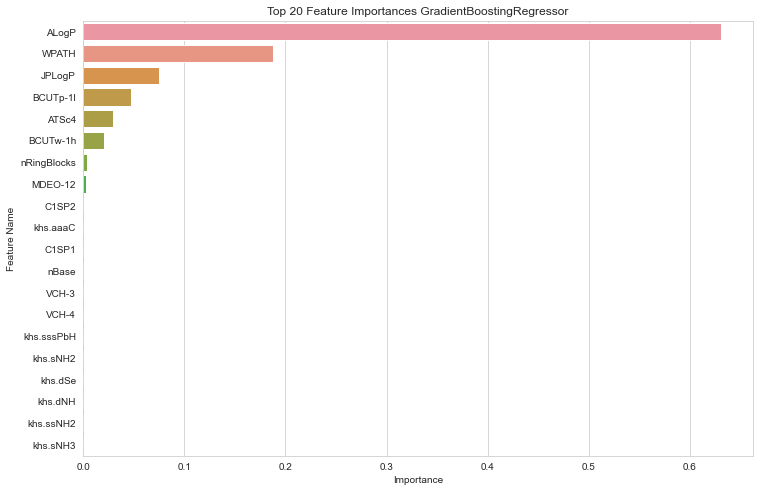

,model,Mean CV,MAE,MAPE,MSE,RMSE,R_Squared,Adjusted_R_Squared
0,LinearRegression,-0.805315,1.090880e+11,3.296793e+10,6.723605e+23,8.199759e+11,-4.967275e+23,-6.784571e+23
1,Lasso,-0.887162,9.734274e-01,7.433510e-01,1.354955e+00,1.164025e+00,-1.015262e-03,-3.672404e-01
2,DecisionTree,-0.664369,4.907985e-01,3.958904e-01,4.757398e-01,6.897389e-01,6.485323e-01,5.199465e-01
3,RandomForest,-0.539165,4.490700e-01,3.446840e-01,4.021617e-01,6.341622e-01,7.028904e-01,5.941917e-01
4,XGBRegressor,-0.511765,4.854216e-01,3.886612e-01,4.544673e-01,6.741419e-01,6.642480e-01,5.414119e-01
5,GradientBoostingRegressor,-0.519993,4.483893e-01,3.638765e-01,4.078666e-01,6.386443e-01,6.986758e-01,5.884352e-01
6,Elastic Net,-0.808434,9.199339e-01,7.141803e-01,1.204527e+00,1.097509e+00,1.101179e-01,-2.154487e-01
7,BayesianRidge,-0.774421,6.973730e-01,5.934655e-01,8.168659e-01,9.038064e-01,3.965146e-01,1.757273e-01
8,CatBoostRegressor,-0.530989,4.645373e-01,3.888652e-01,4.388632e-01,6.624675e-01,6.757760e-01,5.571575e-01
9,LGBMRegressor,-0.533690,4.485061e-01,3.533778e-01,3.925345e-01,6.265257e-01,7.100028e-01,6.039063e-01


In [25]:
selected_features_X = X.iloc[:, list(sfs1.k_feature_idx_)]
y = model_data['logkpl']

train_and_evalute(selected_features_X, y, metric="MAPE")

In [37]:
calc_vif(selected_features_X)

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


,variables,VIF
0,nAtom,4984.386364
1,ATSc3,11.900787
2,ATSc4,8.413273
3,ATSm5,382.720982
4,ATSp5,429.363298
5,BCUTp-1l,124.104834
6,nBase,4.268558
7,nB,7506.930061
8,C1SP1,1.074174
9,C2SP1,NaN


<a id="Feature-Selection-PCA"></a>
### 3.3 Feature Selection using PCA

In [11]:
X = model_data.drop(["logkpl"], axis=1)
y = model_data['logkpl']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

from sklearn.decomposition import PCA


# initilizing and fitting the pca
pca = PCA(n_components=0.99)
X_pca = pca.fit_transform(X_scaled)

print("Number of Components by PCA", X_pca.shape[1])
print("Explained Variance Ratio", pca.explained_variance_ratio_.sum())

Number of Components by PCA 41
Explained Variance Ratio 0.9910310037607606


In [13]:
X_pca.shape

(417, 41)

In [17]:
pca.components_.shape[0]

41

In [18]:
pca.get_params

<bound method BaseEstimator.get_params of PCA(n_components=0.99)>

In [19]:
test_ = pd.DataFrame(pca.components_.T, index = {'PC{}'.format(i+1) for i in range(X_pca.shape[1])}) #columns=X.columns,


ValueError: Shape of passed values is (146, 41), indices imply (41, 41)

In [ ]:
test_

,Texpi,ALogP,ALogp2,AMR,apol,nAcid,naAromAtom,nAromBond,nAtom,ATSc1,...,MW,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb
PC22,-0.031134,0.030326,0.029669,0.114115,0.115273,-0.010320,-0.029310,-0.028832,0.114519,0.052669,...,0.101812,0.115455,0.064667,0.032302,0.060440,-0.018330,0.103617,0.117898,0.023811,0.117122
PC26,0.010533,0.008850,0.010250,-0.002350,-0.004319,-0.001354,0.021178,0.022900,-0.004386,-0.006872,...,0.069261,-0.012309,0.096491,0.133848,-0.005664,0.005569,-0.007815,-0.007042,-0.006046,-0.007859
PC18,0.051618,-0.196747,0.021007,-0.016240,-0.003918,0.019890,-0.137567,-0.136193,0.017040,0.199363,...,0.022298,0.006382,-0.075486,0.122665,0.199015,0.005294,0.056777,0.005852,-0.188817,-0.003149
PC5,0.100162,-0.031766,0.043603,0.046351,0.021389,0.057670,0.202798,0.203425,0.009061,0.114939,...,0.072590,0.061656,0.090736,0.128473,0.064389,0.185328,0.068606,0.021310,-0.029105,0.044390
PC19,0.013156,0.169669,0.171723,0.068874,0.071087,0.008856,0.064905,0.063447,0.075688,-0.055343,...,0.063525,0.028867,0.056302,-0.024750,-0.046111,-0.050427,0.030127,-0.031660,0.162314,-0.012495
PC3,-0.038630,0.022768,-0.123096,0.029593,0.026201,0.075240,-0.064603,-0.062018,0.029834,0.011610,...,-0.035915,0.010416,-0.123941,0.006293,-0.069951,0.210349,0.058728,0.006815,0.005178,0.014053
PC20,0.074036,0.065755,0.129346,0.029632,0.037801,-0.014044,0.073475,0.070509,0.040948,-0.033702,...,-0.069635,0.018906,-0.120407,-0.075146,0.036866,-0.091467,0.038523,0.024288,0.084629,0.035862
PC11,-0.027987,-0.031357,-0.119799,-0.006994,-0.010037,-0.038942,-0.035307,-0.038564,-0.012992,-0.002797,...,-0.015015,-0.010449,-0.052940,-0.000013,-0.021083,0.030460,-0.003296,-0.000883,-0.045563,-0.002798
PC12,0.075948,0.004944,0.053060,-0.003113,0.005771,0.138356,0.012995,0.019829,0.015674,-0.013816,...,-0.019384,0.013657,0.028088,-0.035190,-0.022426,0.063407,0.027432,0.010967,-0.028877,0.007813
PC13,-0.106433,0.033448,-0.016095,0.010013,-0.000685,0.189053,-0.025590,-0.023749,-0.008754,-0.007759,...,0.012833,0.015194,-0.008154,-0.005839,-0.007580,-0.028162,0.083090,-0.001552,0.021814,0.005351


In [21]:
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component i.e. largest absolute value
# using LIST COMPREHENSION HERE
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = X.columns

# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]


X_pca_df = pd.DataFrame(X_pca, columns=most_important_names)

# using LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(sorted(dic.items()))
df[1].duplicated().sum()

9

In [30]:
X.columns.shape

(223,)

In [31]:
most_important

[20,
 205,
 185,
 200,
 92,
 218,
 168,
 203,
 25,
 124,
 33,
 116,
 162,
 143,
 138,
 145,
 146,
 0,
 141,
 129,
 123,
 129,
 100,
 113,
 100,
 5,
 100,
 162,
 13,
 103,
 103,
 145,
 0,
 110,
 13,
 190]

LinearRegression
Lasso
DecisionTree
RandomForest
XGBRegressor
GradientBoostingRegressor
Elastic Net
BayesianRidge
CatBoostRegressor
LGBMRegressor


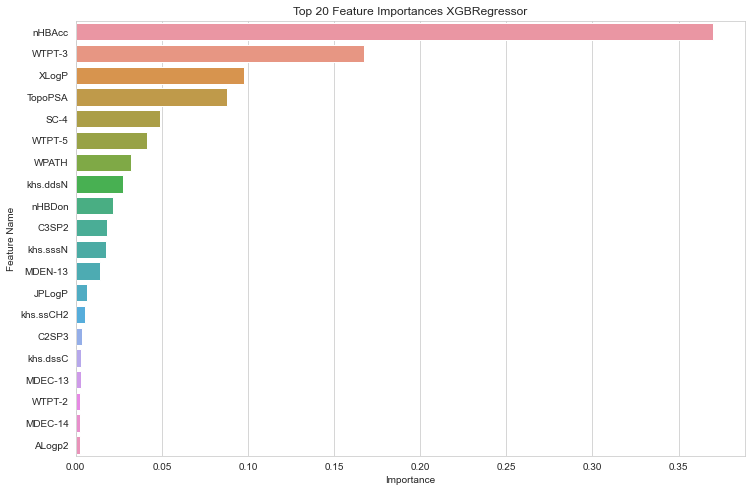

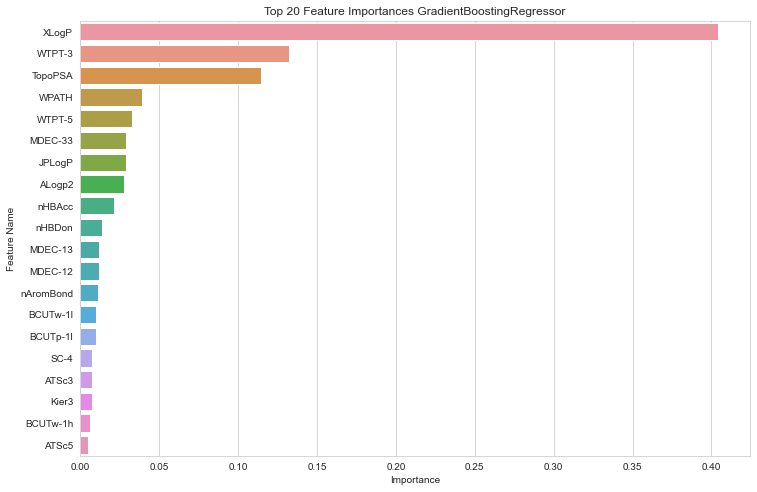

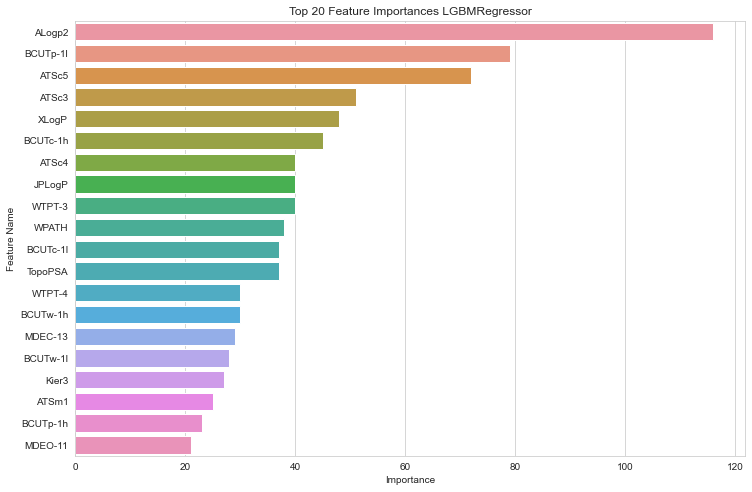

(                       model   Mean CV       MAE      MAPE       MSE  \
 0           LinearRegression -9.213726  0.403418  0.195182  0.290078   
 1                      Lasso -0.787368  0.940829  0.491073  1.219949   
 2               DecisionTree -0.921777  0.362288  0.164284  0.298071   
 3               RandomForest -0.696747  0.328195  0.151616  0.224482   
 4               XGBRegressor -0.760239  0.321688  0.142906  0.222411   
 5  GradientBoostingRegressor -0.713600  0.316432  0.143215  0.216265   
 6                Elastic Net -0.809131  0.857273  0.446738  1.029931   
 7              BayesianRidge -0.904908  0.405359  0.194921  0.288154   
 8          CatBoostRegressor -0.740975  0.333227  0.150834  0.234399   
 9              LGBMRegressor -0.772968  0.319876  0.143260  0.226810   
 
        RMSE  R_Squared  Adjusted_R_Squared  
 0  0.538588   0.752400            1.182752  
 1  1.104513  -0.041304            1.768582  
 2  0.545959   0.745577            1.187788  
 3  0.47379

In [23]:
pca_features = train_and_evalute(X_train, X_test, y_train, y_test, metric="MAPE")
pca_features

In [24]:
pca_features

(                       model   Mean CV       MAE      MAPE       MSE  \
 0           LinearRegression -9.213726  0.403418  0.195182  0.290078   
 1                      Lasso -0.787368  0.940829  0.491073  1.219949   
 2               DecisionTree -0.921777  0.362288  0.164284  0.298071   
 3               RandomForest -0.696747  0.328195  0.151616  0.224482   
 4               XGBRegressor -0.760239  0.321688  0.142906  0.222411   
 5  GradientBoostingRegressor -0.713600  0.316432  0.143215  0.216265   
 6                Elastic Net -0.809131  0.857273  0.446738  1.029931   
 7              BayesianRidge -0.904908  0.405359  0.194921  0.288154   
 8          CatBoostRegressor -0.740975  0.333227  0.150834  0.234399   
 9              LGBMRegressor -0.772968  0.319876  0.143260  0.226810   
 
        RMSE  R_Squared  Adjusted_R_Squared  
 0  0.538588   0.752400            1.182752  
 1  1.104513  -0.041304            1.768582  
 2  0.545959   0.745577            1.187788  
 3  0.47379

<a id="ann"></a>
# 4. ANN